<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/kb_10xv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
install.packages("BiocManager")
BiocManager::install(c("multtest", "DropletUtils", "BUSpaRse", "TENxBUSData"))
install.packages(c("Seurat", "biomartr", "data.table"))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'BiocVersion', 'multtest', 'DropletUtils', 'BUSpaRse',
  'TENxBUSData'

also installing the dependencies ‘formatR’, ‘bit’, ‘vctrs’, ‘lambda.r’, ‘futile.options’, ‘matrixStats’, ‘bit64’, ‘blob’, ‘DBI’, ‘zlibbioc’, ‘bitops’, ‘Rhtslib’, ‘SummarizedExperiment’, ‘futile.logger’, ‘snow’, ‘limma’, ‘locfit’, ‘DelayedArray’, ‘IRanges’, ‘R.oo’, ‘R.methodsS3’, ‘sitmo’, ‘RSQLite’, ‘XML’, ‘BiocFileCache’, ‘rappdirs’, ‘XVector’, ‘rtracklayer’, ‘Rsamtools’, ‘ProtGenerics’, ‘RCurl’, ‘GenomeInfoDbData’, ‘GenomicAlignments’, ‘interactiveDisplayBase’, ‘BiocGenerics’, ‘Biobase’, ‘SingleCellExperiment’, ‘S4Vectors’, ‘BiocParallel’, ‘edgeR’, ‘rhdf5’, ‘HDF5Array’, ‘R.utils’, ‘dqrng’, ‘beachmat’, ‘Rhdf5lib’, ‘AnnotationDbi’, ‘AnnotationFilter’, ‘biomaRt’, ‘Biostrings’, ‘BSgenome’, ‘data.table’, ‘ensembldb’, ‘GenomeInfoDb’, ‘GenomicFeatu

In [0]:
library(BUSpaRse)
library(TENxBUSData)
library(ggplot2)
library(magrittr)
library(data.table)
library(Seurat)
library(DropletUtils)
library(Matrix)
library(tibble)
theme_set(theme_bw())

We will not get into the details of how to make the `bus` file with `kallisto bus` and `bustools`, as the data will be downloaded with `TENxBUSData`. `TENxBUSData` provides 5 different datasets, and we will use the PBMC 1k dataset here. The data from `TENxBUSData` contains the sorted `bus` file in text format. While the `BUSpaRse` package converts that text format `bus` file into gene count matrix, this text file can be loaded into R as a data frame for further exploration.

In [0]:
fn <- TENxBUSData(".", dataset = "pbmc1k")

In [0]:
list.files(fn)

[1] "matrix.ec"         "output.sorted"     "output.sorted.txt"
[4] "transcripts.txt"

Explaining the output:

* `matrix.ec`: A text file with two columns. The first column is the 0 based index of equivalence classes. The second column is the set of transcripts (denoted by 0 based index based on order of appearance in the transcriptome fasta file) present in the corresponding equivalence class.
* `output.sorted`: The data represented in `bus` format, sorted by barcode, UMI, and equivalence class. This is a binary, so can't be read into R with functions like `read.table`.
* `output.sorted.txt`: `output.sorted` converted into text format, so can be easily read into R for exploration.
* `transcript.txt`: A text file with one column, which is the transcripts present in the data, in the same order as in the transcriptome fasta file.

# Sparse matrix
## Map transcripts to genes
For the sparse matrix, most people are interested in how many UMIs per gene per cell, we here we will quantify this from the `bus` output, and to do so, we need to find which gene corresponds to each transcript. Remember in the output of `kallisto bus`, there's the file `transcripts.txt`. Those are the transcripts in the transcriptome index. Information on which transcript corresponds to which gene can be directly retrieved from Ensembl.

In [0]:
tr2g <- transcript2gene(species = "Homo sapiens", 
                        kallisto_out_path = "./out_pbmc1k",
                        ensembl_version = 94)

Querying biomart for transcript and gene IDs of Homo sapiens

Sorting transcripts



In [0]:
head(tr2g)

transcript,gene,gene_name
<chr>,<chr>,<chr>
ENST00000632684.1,ENSG00000282431.1,TRBD1
ENST00000434970.2,ENSG00000237235.2,TRDD2
ENST00000448914.1,ENSG00000228985.1,TRDD3
ENST00000415118.1,ENSG00000223997.1,TRDD1
ENST00000631435.1,ENSG00000282253.1,TRBD1
ENST00000390583.1,ENSG00000211923.1,IGHD3-10


Alternative ways of getting `tr2g` have been implemented in the `BUSpaRse` package. You may use `tr2g_ensembl` to query Ensembl with biomart to get transcript and gene IDs. If you use this method, then please make sure that the Ensembl version used in the query matches that of the transcriptome. This method is convenient for the user since you only need to input species names, but it can be slow since biomart database query can be slow. You may also use `tr2g_gtf` for GTF files and `tr2g_gff3` for GFF3 files, which are more useful for non-model organisms absent from Ensemble. After calling the `tr2g_*` family of functions, you should sort the transcripts from those functions with `sort_tr2g` so the transcripts are in the same order as those in the kallisto index. Then the function `save_tr2g_bustools` can be used to save the `tr2g` data frame to a text file in the format required by `bustools`.

## Make the sparse matrix
For 10x, we do have a file with all valid cell barcodes that comes with CellRanger. You need to install CellRanger to get this file, though you do not need to run CellRanger for this notebook. The whitelist is optional, so if you don't have one, you may skip the whitelist step and the `whitelist` argument in the `makr_sparse_matrix` function. 

In [0]:
if (!dir.exists("./reference")) dir.create("./reference")
download.file("https://caltech.box.com/public/static/q078m83pq1yumorcsbsom7en6m6uonqa.gz", 
destfile = "./reference/whitelist_v3.txt.gz", method = "wget")

In [0]:
# Read in the whitelist
whitelist_v3 <- fread("./reference/whitelist_v3.txt.gz", header = FALSE)$V1
length(whitelist_v3)

[1] 6794880

That's an order of magnitude more than the 737K in v2 chemistry.

Now we have everything we need to make the sparse matrix. This function reads in `output.sorted.txt` line by line and processes them. It does not do barcode correction for now, so the barcode must exactly match those in the whitelist if one is provided. It took 5 to 6 minutes to construct the sparse matrix in the hgmm6k dataset, which has over 280 million lines in `output.sorted.txt`, which is over 9GB. Here the data set is smaller, and it takes less than a minute. 

Note that the arguments `est_ncells` (estimated number of cells) and `est_ngenes` (estimated number of genes) are important. With the estimate, this function reserves memory for the data to be added into, reducing the need of reallocation, which will slow the function down. Since the vast majority of "cells" you get in this sparse matrix are empty droplets rather than cells, please put at least 200 times more "cells" than you actually expect in `est_ncells`.

If you do not have a whitelist of barcodes, then it's fine; the `whitelist` argument is optional.

The function `make_sparse_matrix` can make the gene count matrix and the transcript compatibility count (TCC) matrix at the same time. For the purpose of this notebook, we only generate the gene count matrix. An upcoming notebook will demonstrate some more detailed analysis with a TCC matrix. See [Ntranos et al. 2016](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0970-8) for more information about TCC matrices.

In [0]:
res_mat <- make_sparse_matrix("./out_pbmc1k/output.sorted.txt",
                              tr2g = tr2g, est_ncells = 3e5,
                              est_ngenes = nrow(tr2g),
                              whitelist = whitelist_v3, TCC = FALSE)

Reading matrix.ec
Processing ECs
Matching genes to ECs
Reading data
Read 5 million reads
Read 10 million reads
Read 15 million reads
Constructing gene count matrix


The matrix we get has genes in rows and barcode in columns. The row names are the gene IDs (not using human readable gene names since they're not guaranteed to be unique), and the column names are cell barcodes.

# Explore the data
## Remove empty droplets
Cool, so now we have the sparse matrix. What does it look like?

In [0]:
dim(res_mat)

[1]  19821 216752

That's way more cells than we expect, which is about 1000. So what's going on?

How many UMIs per barcode?

In [0]:
tot_counts <- Matrix::colSums(res_mat)
summary(tot_counts)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    1.00     1.00     2.00    46.49     6.00 54175.00 

The vast majority of "cells" have only a few UMI detected. Those are empty droplets. 10x claims to have cell capture rate of up to 65%, but in practice, depending on how many cells are in fact loaded, the rate can be much lower. A commonly used method to estimate the number of empty droplets is barcode ranking knee and inflection points, as those are often assumed to represent transition between two components of a distribution. While more sophisticated method exist (e.g. see [`emptyDrops` in `DropletUtils`](https://www.bioconductor.org/packages/devel/bioc/vignettes/DropletUtils/inst/doc/DropletUtils.html#detecting-empty-droplets)), for simplicity, we will use the barcode ranking method here. However, whichever way we go, we don't have the ground truth.

In [0]:
# Compute barcode rank
bc_rank <- barcodeRanks(res_mat)

In [0]:
#' Knee plot for filtering empty droplets
#' 
#' Visualizes the inflection point to filter empty droplets. This function plots 
#' different datasets with a different color. Facets can be added after calling
#' this function with `facet_*` functions.
#' 
#' @param bc_rank A `DataFrame` output from `DropletUtil::barcodeRanks`.
#' @return A ggplot2 object.
knee_plot <- function(bc_rank) {
  knee_plt <- data.frame(rank = bc_rank[["rank"]],
                         total = bc_rank[["total"]]) %>% 
    distinct() %>% 
    dplyr::filter(total > 0)
  annot <- data.frame(inflection = metadata(bc_rank)[["inflection"]],
                      rank_cutoff = max(bc_rank$rank[bc_rank$total > metadata(bc_rank)[["inflection"]]]))
  p <- ggplot(knee_plt, aes(rank, total)) +
    geom_line() +
    geom_hline(aes(yintercept = inflection), data = annot, linetype = 2) +
    geom_vline(aes(xintercept = rank_cutoff), data = annot, linetype = 2) +
    scale_x_log10() +
    scale_y_log10() +
    annotation_logticks() +
    labs(x = "Rank", y = "Total UMIs")
  return(p)
}

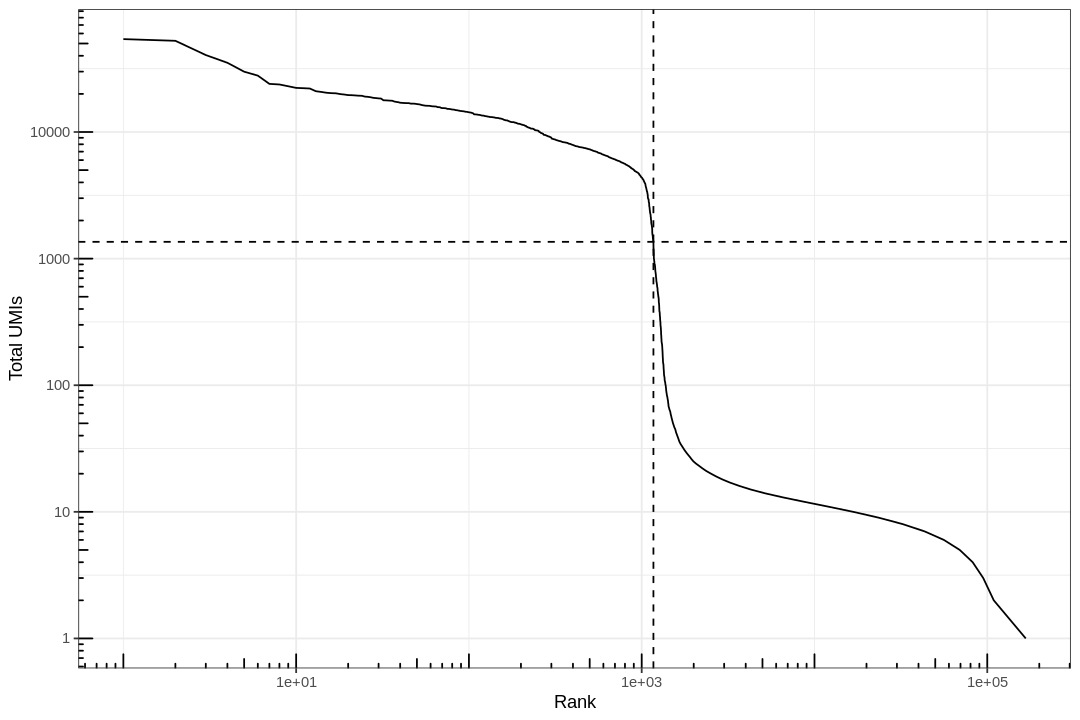

In [0]:
options(repr.plot.width=9, repr.plot.height=6)
knee_plot(bc_rank)

The inflection point looks like a reasonable number of cells.

In [0]:
# Filter the matrix
res_mat <- res_mat[, tot_counts > metadata(bc_rank)$inflection]
res_mat <- res_mat[Matrix::rowSums(res_mat) > 0,]
dim(res_mat)

[1] 19662  1169

## Dimension reduction

In [0]:
seu <- CreateSeuratObject(res_mat, min.cells = 3) %>% 
  SCTransform(verbose = FALSE)

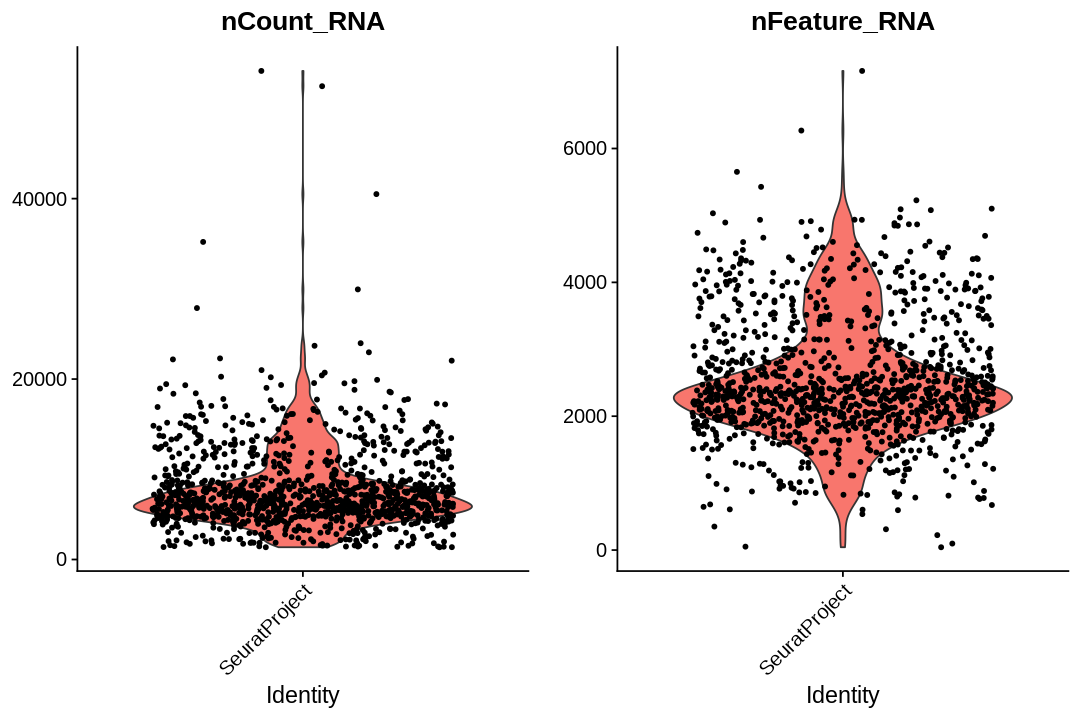

In [0]:
VlnPlot(seu, c("nCount_RNA", "nFeature_RNA"))

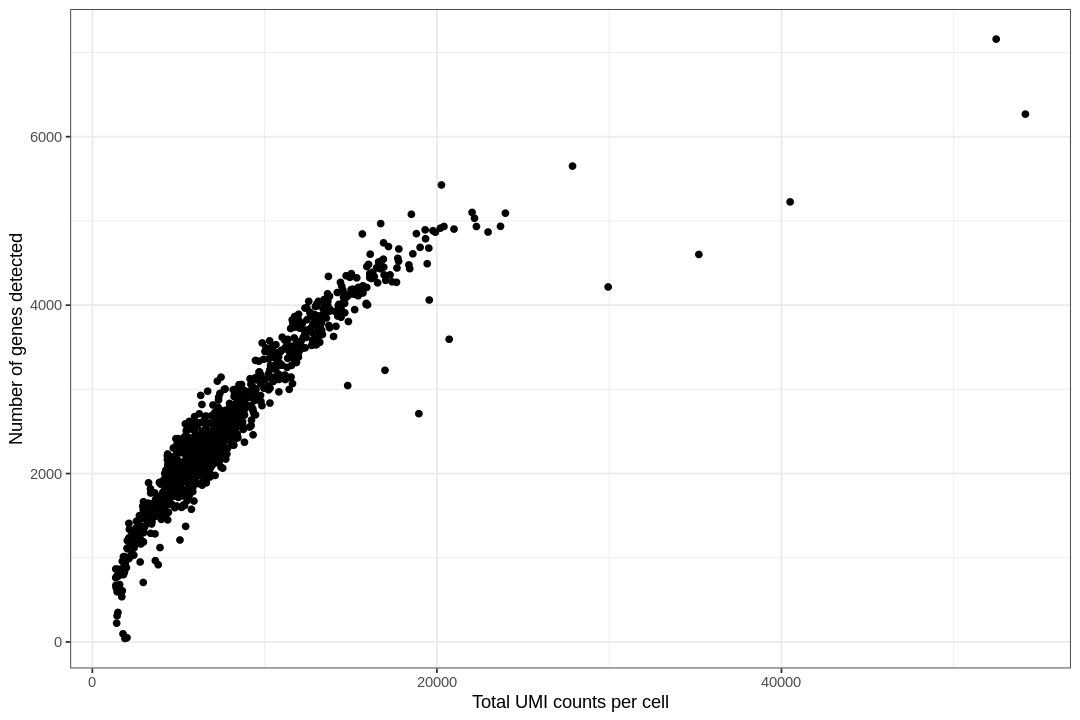

In [0]:
ggplot(seu@meta.data, aes(nCount_RNA, nFeature_RNA)) +
  geom_point() +
  labs(x = "Total UMI counts per cell", y = "Number of genes detected")

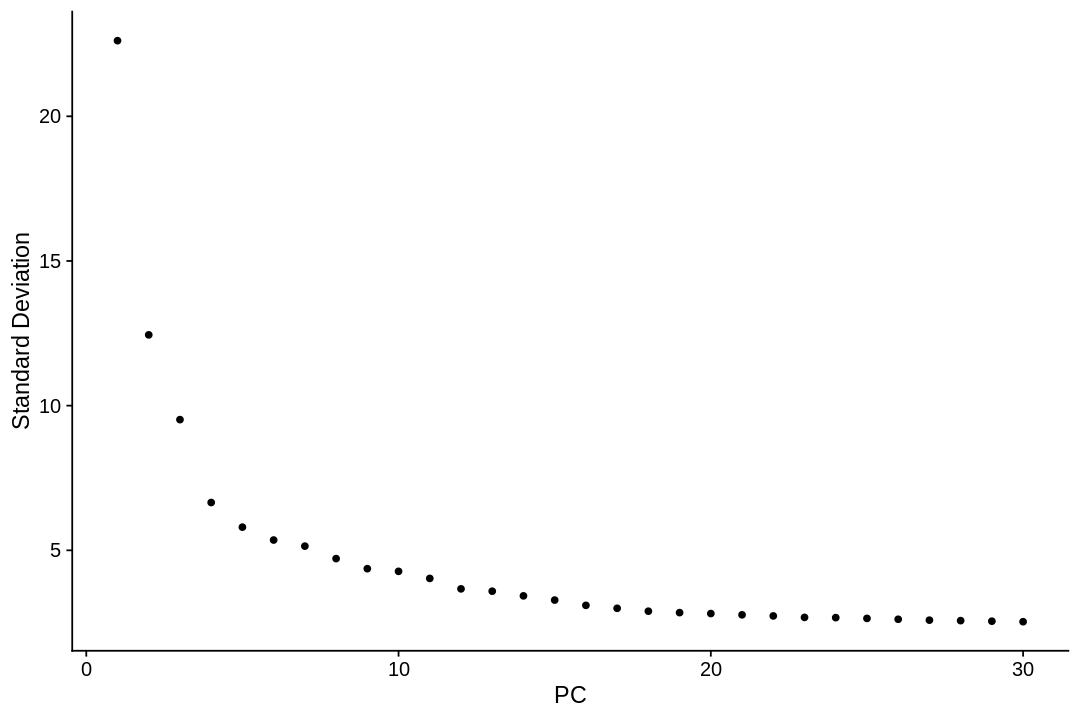

In [0]:
seu <- RunPCA(seu, verbose = FALSE, npcs = 30)
ElbowPlot(seu, ndims = 30)

In [0]:
seu <- FindNeighbors(seu)
seu <- FindClusters(seu)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1169
Number of edges: 35688

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8463
Number of communities: 11
Elapsed time: 0 seconds


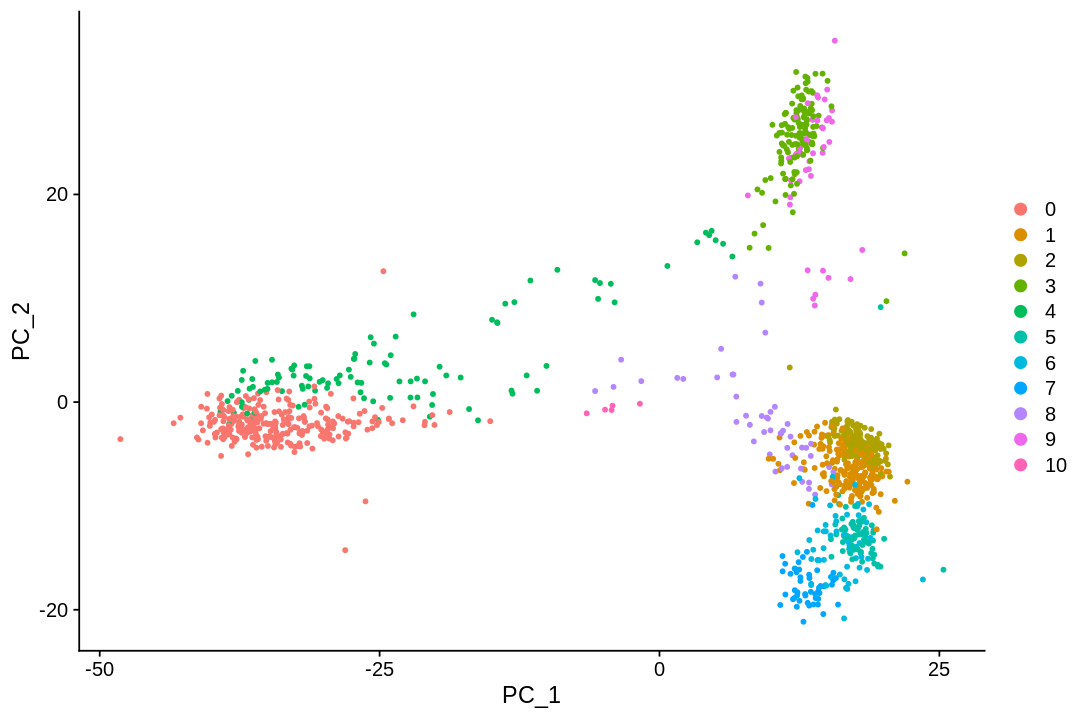

In [0]:
PCAPlot(seu)

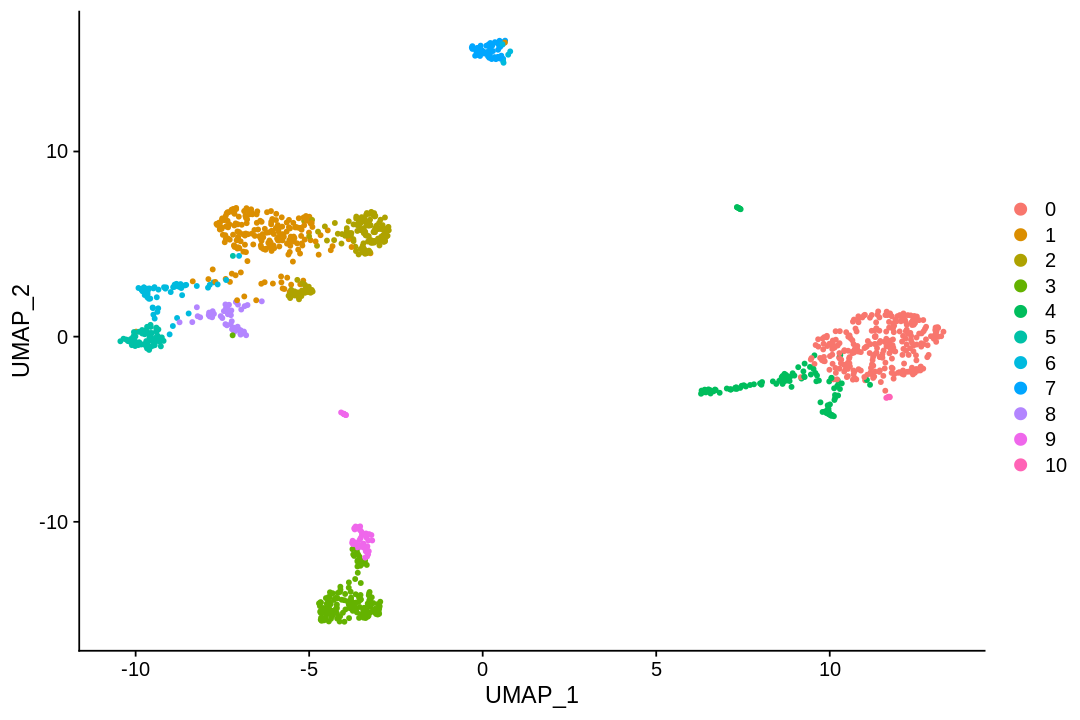

In [0]:
seu <- RunUMAP(seu, dims = 1:20, verbose = FALSE)
UMAPPlot(seu)